# 問題1 スクラッチを振り返る

重みの定義<br>
重みの初期化<br>
forward処理、backward処理<br>
勾配の算出<br>
重みの更新<br>
バッチの生成<br>
等々

# 問題2 スクラッチとTensorFlowの対応を考える

In [118]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


In [56]:
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100

n_input = X_train.shape[1]
print(n_input)
n_samples = X_train.shape[0]
print(n_samples)
n_classes =1#二値分類



get_mini_batch_train = GetMiniBatch(X_train, y_train,
                                   batch_size = batch_size)

4
64


In [75]:
def example_net(x):
    weights = {
        'w1' : tf.Variable(tf.random.normal([n_input, n_hidden1])),
        'w2' : tf.Variable(tf.random.normal([n_hidden1, n_hidden2])),
        'w3' : tf.Variable(tf.random.normal([n_hidden2, n_classes]))
    }
    
    bias = {
        'b1' : tf.Variable(tf.random.normal([n_hidden1])),
        'b2' : tf.Variable(tf.random.normal([n_hidden2])),
        'b3' : tf.Variable(tf.random.normal([n_classes]))
    }
    print(weights['w1'])
    print(x)
    layer_1 = tf.matmul(x, weights['w1']) + bias['b1']
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.matmul(layer_1, weights['w2']) + bias['b2']
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + bias['b3']
    return layer_output


In [82]:
g1 = tf.Graph()
with g1.as_default():
    X = tf.placeholder('float', [None, n_input])
    Y = tf.placeholder('float', [None, n_classes])
    logits = example_net(X)
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=Y, logits=logits))

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_op)

    correct_pred = tf.equal(tf.sign(Y - 0.5),
                            tf.sign(tf.nn.sigmoid(logits) - 0.5))

    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

<tf.Variable 'Variable:0' shape=(4, 50) dtype=float32_ref>
Tensor("Placeholder:0", shape=(?, 4), dtype=float32)


In [83]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        
        total_batch = np.ceil(X_train.shape[0] / batch_size).astype(
        np.int)
        total_loss = 0
        total_acc = 0
        count = 0
        for i ,(mini_batch_x, mini_batch_y) in enumerate(
            get_mini_batch_train):
            
            sess.run(train_op, feed_dict={X : mini_batch_x, Y : mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                X : mini_batch_x, Y : mini_batch_y
            })
            total_loss += loss
            total_acc += acc
            count += 1
        
        print(count)    
        total_loss /= total_batch
        total_acc /= total_batch
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={
            X : X_val, Y : y_val
        })
        print('Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f},'
              'val_acc : {:.3f}'.format(epoch, loss, val_loss, acc, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict = {X : X_test, Y : y_test})
    print('test_acc : {:.3f}'.format(test_acc))
        

7
Epoch 0, loss : 14.8255, val_loss : 7.5329, acc : 0.250,val_acc : 0.625
7
Epoch 1, loss : 3.5030, val_loss : 5.6117, acc : 0.750,val_acc : 0.375
7
Epoch 2, loss : 0.0000, val_loss : 0.0000, acc : 1.000,val_acc : 1.000
7
Epoch 3, loss : 0.0047, val_loss : 0.1756, acc : 1.000,val_acc : 0.875
7
Epoch 4, loss : 0.0007, val_loss : 0.3373, acc : 1.000,val_acc : 0.875
7
Epoch 5, loss : 0.0018, val_loss : 1.4326, acc : 1.000,val_acc : 0.812
7
Epoch 6, loss : 0.0160, val_loss : 1.2918, acc : 1.000,val_acc : 0.812
7
Epoch 7, loss : 0.0000, val_loss : 1.8140, acc : 1.000,val_acc : 0.812
7
Epoch 8, loss : 0.0769, val_loss : 1.9256, acc : 1.000,val_acc : 0.688
7
Epoch 9, loss : 0.0000, val_loss : 2.2305, acc : 1.000,val_acc : 0.812
test_acc : 0.850


# 問題3 3種類全ての目的関数を使用したIrisのモデルを作成

In [150]:
g = tf.Graph()
get_mini_batch_train = GetMiniBatch(X_train, y_train_onehot,
                                       batch_size = batch_size)
learning_rate = 0.01
batch_size = 8
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100

n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes =3


with g.as_default():
    

    X = tf.placeholder('float', [None, n_input])
    Y = tf.placeholder(tf.int64, [None, n_classes])
    
    
    logits = example_net(X)
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=Y, logits=logits
    ))
    optimzier = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)
    
    print(tf.nn.softmax(logits))
    print(tf.argmax(Y,axis=1))
    print(tf.argmax(tf.nn.softmax(logits),axis=1))
    correct_pred = tf.equal(tf.argmax(Y,axis=1),
                            tf.argmax(tf.nn.softmax(logits),
                                        axis=1))
    print(correct_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    

<tf.Variable 'Variable:0' shape=(4, 50) dtype=float32_ref>
Tensor("Placeholder:0", shape=(?, 4), dtype=float32)
Tensor("Softmax:0", shape=(?, 3), dtype=float32)
Tensor("ArgMax:0", shape=(?,), dtype=int64)
Tensor("ArgMax_1:0", shape=(?,), dtype=int64)
Tensor("Equal:0", shape=(?,), dtype=bool)


In [152]:


with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        total_loss = 0
        total_acc = 0
        batch_num = len(get_mini_batch_train)
        for i, (mini_batch_x, mini_batch_y) in enumerate(
            get_mini_batch_train):
            sess.run(train_op, feed_dict={X : X_train, Y : y_train_onehot})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={
                X : X_train, Y : y_train_onehot
            })
            total_loss += loss
            total_acc += acc
        mean_loss = total_loss / batch_num
        mean_acc = total_acc / batch_num
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={
            X : X_val, Y : y_val_onehot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc :"
              "{:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        
        
    test_acc = sess.run(accuracy, feed_dict={X: X_test,
                                             Y : y_test_onehot})
    print("test_acc : {:.3f}".format(test_acc))
        
        

        
        

Epoch 0, loss : 9.1611, val_loss : 14.4546, acc :0.698, val_acc : 0.708
Epoch 1, loss : 0.1399, val_loss : 1.2416, acc :0.969, val_acc : 0.792
Epoch 2, loss : 0.2084, val_loss : 2.5165, acc :0.979, val_acc : 0.917
Epoch 3, loss : 0.0517, val_loss : 1.1156, acc :0.990, val_acc : 0.875
Epoch 4, loss : 0.0629, val_loss : 1.0172, acc :0.990, val_acc : 0.875
Epoch 5, loss : 0.0162, val_loss : 1.2307, acc :0.990, val_acc : 0.917
Epoch 6, loss : 0.0027, val_loss : 1.3786, acc :1.000, val_acc : 0.917
Epoch 7, loss : 0.0011, val_loss : 1.5838, acc :1.000, val_acc : 0.917
Epoch 8, loss : 0.0008, val_loss : 1.5362, acc :1.000, val_acc : 0.917
Epoch 9, loss : 0.0008, val_loss : 1.4836, acc :1.000, val_acc : 0.917
test_acc : 1.000


In [133]:
import keras
from sklearn.preprocessing import OneHotEncoder
df = pd.read_csv(dataset_path)
ohe = OneHotEncoder(sparse=False)
y = np.array(df["Species"])
X =np.array(df.loc[:, ["SepalLengthCm",
              "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]])
y_onehot = ohe.fit_transform(y.reshape(-1,1))
print(y_onehot.shape)
print(X.shape)
X_train,X_test, y_train_onehot, y_test_onehot = \
train_test_split(X,y_onehot,test_size=0.2, random_state=0)
X_train,X_val, y_train_onehot, y_val_onehot = \
train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=0)
                          

(150, 3)
(150, 4)


In [134]:
print(X_val.shape)
print(X_test.shape)
print(y_val_onehot.shape)
print(type(y_train_onehot))
print(type(X_train))
print(type(y_train_onehot))

(24, 4)
(30, 4)
(24, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [138]:
del X

# 問題4 House Pricesのモデルを作成

In [171]:
df_house = pd.read_csv('../train.csv')
df_house.head()
X = np.array(df_house.loc[:, ['GrLivArea', 'YearBuilt']])
y = np.array(df_house.loc[:,'SalePrice']).reshape(-1,1)
print(X.shape)
print(y.shape)

(1460, 2)
(1460, 1)


(1168, 1)
Generation:25, loss = 70648.62
Generation:50, loss = 61711.04
Generation:75, loss = 53303.69
Generation:100, loss = 47214.566
Generation:125, loss = 45400.625
Generation:150, loss = 41587.562
Generation:175, loss = 34968.24
Generation:200, loss = 35285.492
Generation:225, loss = 32975.914
Generation:250, loss = 25111.24
Generation:275, loss = 32852.617
Generation:300, loss = 26303.143
Generation:325, loss = 36255.637
Generation:350, loss = 28972.885
Generation:375, loss = 30563.9
Generation:400, loss = 33333.7
Generation:425, loss = 28410.117
Generation:450, loss = 28172.062
Generation:475, loss = 34279.984
Generation:500, loss = 31311.1
Generation:525, loss = 23361.81
Generation:550, loss = 27215.805
Generation:575, loss = 26992.457
Generation:600, loss = 29090.742
Generation:625, loss = 32155.223
Generation:650, loss = 25640.045
Generation:675, loss = 28307.402
Generation:700, loss = 34595.402
Generation:725, loss = 28272.953
Generation:750, loss = 33218.086
Generation:775,

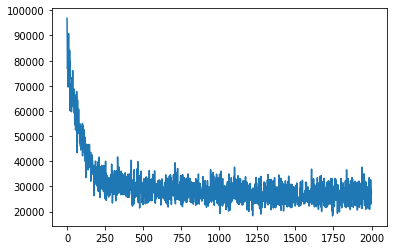

In [193]:
from sklearn.preprocessing import StandardScaler
sr = StandardScaler()
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,
                                                  random_state=0)
print(y_train.shape)

X_train_std = sr.fit_transform(X_train)
X_test_std = sr.transform(X_test)

network = nnet(X_train_std)
model = network.fit(X_train_std, y_train, hidden_size=[25,10,3],
                    iter_size=2000)
pred = network.predict(model, X_test_std)
print(pred)


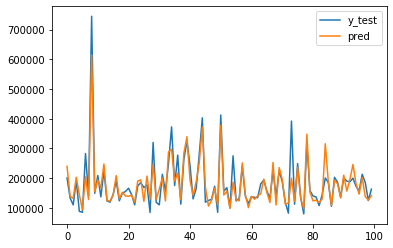

In [200]:
plt.plot(y_test[:100], label='y_test')
plt.plot(pred[:100], label='pred')
plt.legend(loc='best')

In [189]:
import matplotlib.pyplot as plt
class nnet:
    
    def __init__(self, X, random_state=3):
        #セッションの生成
        self.sess = tf.Session()
        #乱数の固定
        seed = random_state
        tf.set_random_seed(seed)
        np.random.seed(seed)
        #入力変数の定義
        self.x_data = tf.placeholder(shape=[None, X.shape[1]], 
                                    dtype=tf.float32)
        self.y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
             
        
    def init_weight(self, shape, st_dev):
        
        '''
        Attribute=>
        shape: wの形状
        st_dev: 標準偏差の設定
        
        '''
        
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))
    
    def init_bias(self, shape, st_dev):
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))
    
    def fully_connected(self, input_layer, weights, biases):
        return tf.nn.relu(tf.add(tf.matmul(input_layer, weights), biases))

    
    
    def fit(self, X, y, hidden_size, batch_size=100, iter_size=2000):
#         print('y.shape: ', y.shape)
        
        x_data = self.x_data
        y_target = self.y_target
        
        final_output = self.build_hidden_layer(hidden_size, X.shape[1])
        
        self.loss = tf.reduce_mean(tf.abs(y_target - final_output))
        self.opt = tf.train.AdamOptimizer(0.01)
        self.train_step = self.opt.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        loss_vec = self.train(X, y, iter_size, batch_size)
        plt.plot(loss_vec)
        return final_output
    
    
    
    def predict(self, final_output, X):
        x_data = self.x_data
        return self.sess.run(final_output, feed_dict={x_data : X})    
    
    


    def train(self, X, y, iter_size, batch_size):
        loss_vec = []
        x_data = self.x_data#placeholderを代入した変数。
        #これ自体は空の箱であり、引数で受け取ったXを
        #最終的にこのplacehoderに格納する
        y_target = self.y_target
        
        #Xからデータをランダムに抽出し、構築した計算グラフを
        #使ってtrainを回す。
        for i in range(iter_size):
            rand_index = np.random.choice(len(X), batch_size)
            rand_x = X[rand_index]
            rand_y = y[rand_index]#transposeによる転置
#             print('randxshape: ', rand_x.shape)
#             print('randyshape: ', rand_y.shape)
            self.sess.run(self.train_step, feed_dict={x_data : rand_x,
                                                     y_target : rand_y})
            loss = self.sess.run(self.loss, feed_dict = {x_data : rand_x,
                                                        y_target : rand_y})
            loss_vec.append(loss)
            
            if (i+1) % 25 == 0:
                print('Generation:' + str(i+1) + ', loss = ' + str(loss_vec[-1]))
        print('loss_veclen: ', len(loss_vec))        
        return loss_vec
    
    
    
    
    
    def build_hidden_layer(self, hidden_size, col_size):
        '''
        Description:隠れ層をまとめて生成する。
        hidden_sizeが隠れ層のサイズのリストとなり、
        入力xのcol_sizeを元に、一連の隠れ層を生成していく
        '''
        weights = []#それぞれの層のweightsをリストに格納
        biases = []
        layers = []
        tmp_size = col_size#Xの特徴量数
        x_data = self.x_data
        last_layer = x_data#今まで構築した最後のレイヤで更新していく
        
        for hsize in hidden_size:
            weights.append(self.init_weight(shape=[tmp_size, hsize],
                                            st_dev=10.0))
            biases.append(self.init_bias(shape=[hsize], st_dev=10.0))
            #weight,bias,入力値の線形結合に活性化関数を適用する一連の
            #流れをfully_connectedで実行
            layers.append(self.fully_connected(last_layer, weights[-1],
                                              biases[-1]))
            #更新
            tmp_size = hsize
            last_layer = layers[-1]
            
       #最後の隠れ層を全結合する     
        weights.append(self.init_weight(shape=[tmp_size,1],
                                        st_dev=10.0))
        biases.append(self.init_bias(shape=[1],
                                      st_dev=10.0))
#         print(last_layer.shape)
#         print(weights[-1].shape)
        layers.append(self.fully_connected(last_layer, weights[-1],biases[-1]))
        final_output = layers[-1]
        
        return final_output
    
    
        
        
            
        
            
        
        
        

# 問題5 MNISTのモデルを作成

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())
print(X_train.min())
print(X_train.shape)
print(y_train.shape)

X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]
print(X_train.shape)
y_train_one_hot = to_categorical(y_train, num_classes=10)
print(y_train.shape)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
print(type(y_train_one_hot))


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot,
                                                 test_size=0.2)

Using TensorFlow backend.


1.0
0.0
(60000, 28, 28)
(60000,)
(60000, 28, 28, 1)
(60000,)
(60000, 10)
float32
<class 'numpy.ndarray'>


In [77]:
import tensorflow as tf
import keras.backend as K
K.clear_session()
conv1_params = {'filter' : [5, 5, 1, 6],
                           'strides' : [1,1,1,1],
                           'padding' : 'SAME',
                           }

conv2_params = {'filter' : [5, 5, 6, 16],
                           'strides' : [1,1,1,1],
                           'padding' : 'VALID',
                           }

conv3_params = {'filter' : [5, 5, 16, 120],
                           'strides' : [1,1,1,1],
                           'padding' : 'VALID',
                           }

affine1_params = {'input_shape' : 120, 'hidden_size' : 84}
affine2_params = {'input_shape' : 84, 'hidden_size' : 10}


network = convnet(input_shape=[28,28,1],n_classes=10,
                  conv1_params=conv1_params, conv2_params=conv2_params,
                  conv3_params=conv3_params,
                  affine1_params=affine1_params,
                  affine2_params=affine2_params)


In [78]:
loss_list = network.fit(X_train, y_train, 10000, 10)

6
weightshape:  <tf.Variable 'Variable:0' shape=(5, 5, 1, 6) dtype=float32_ref>
biasshape:  <tf.Variable 'Variable_1:0' shape=(6,) dtype=float32_ref>
Tensor("Conv2D:0", shape=(?, 28, 28, 6), dtype=float32)
True
16
weightshape:  <tf.Variable 'Variable_2:0' shape=(5, 5, 6, 16) dtype=float32_ref>
biasshape:  <tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>
Tensor("Conv2D_1:0", shape=(?, 10, 10, 16), dtype=float32)
True
120
weightshape:  <tf.Variable 'Variable_4:0' shape=(5, 5, 16, 120) dtype=float32_ref>
biasshape:  <tf.Variable 'Variable_5:0' shape=(120,) dtype=float32_ref>
Tensor("Conv2D_2:0", shape=(?, 1, 1, 120), dtype=float32)
False
120
affine_weights:  <tf.Variable 'Variable_6:0' shape=(120, 84) dtype=float32_ref>
affine_biases:  <tf.Variable 'Variable_7:0' shape=(84,) dtype=float32_ref>
last_layer:  Tensor("Reshape:0", shape=(?, 120), dtype=float32)
affine_weights:  <tf.Variable 'Variable_8:0' shape=(84, 10) dtype=float32_ref>
affine_biases:  <tf.Variable 'Variable_9:0' s

In [79]:
print(type(X_val))
# acc = accuracy.eval(feed_dict={x_data : X,
#                                                y_data : y})
y_pred = network.predict(X_val)
y_val_label = np.argmax(y_val, axis=1)
print('y_val: ', y_val_label)
print('y_pred: ', y_pred)

<class 'numpy.ndarray'>
y_pred :  [6 3 1 ... 4 0 1]
y_val:  [6 3 1 ... 4 0 4]
y_pred:  None


In [71]:
class convnet:
    
    '''
    conv_params: 
    'filter' : shape[fh, fw, c, fn]
    'strides' : stride
    'padding' : padding
    
    '''
    
    def __init__(self,input_shape,n_classes, conv1_params, conv2_params, conv3_params,
                affine1_params, affine2_params, random_state=3):
        
        self.sess = tf.Session()
        np.random.seed(random_state)
        tf.set_random_seed(random_state)
        
        self.conv_params_list = [conv1_params, conv2_params,
                                 conv3_params]
                      
        self.affine_params_list = [affine1_params, affine2_params]
        
        self.x_data = tf.placeholder(dtype=tf.float32,
                                     shape=[None,input_shape[0],
                                            input_shape[1], input_shape[2]])
        self.y_data = tf.placeholder(dtype=tf.float32,
                                    shape=[None, n_classes])
        
        
    def init_weight(self, shape, std):
        return tf.Variable(tf.random_normal(shape=shape,
                                           stddev=std))
    
    def init_bias(self, shape, std):
        return tf.Variable(tf.random_normal(shape=shape,
                                           stddev=std))
        
        
    def fit(self, X, y, batch_size=100, epochs=10):
        x_data = self.x_data
        y_data = self.y_data
        
        final_output = self.generate_model(X.shape[1])
        self.final_output = final_output
        print(final_output)
        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=y_data,
            logits=final_output))
        print('self.loss: ', self.loss)
        
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(final_output, axis=1),
                                tf.argmax(y_data,axis=1)), tf.float64))
        print('accuracy: ', self.accuracy)
        self.opt = tf.train.AdamOptimizer(0.05)
        self.train_step = self.opt.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.loss_vec = self.train(X, y, epochs, batch_size)
        return final_output
    
    
    def train(self, X,y, epochs, batch_size):
        loss_vec = []
        x_data = self.x_data
        y_target = self.y_data
        batch_num = np.ceil(X.shape[0] / batch_size).astype(np.int64)
        self.loss_list = []
        self.acc_list = []
        
        for epoch in range(epochs):
            ep_loss_list = []
            ep_acc_list = []
            
            for num in range(batch_num):
                rand_index = np.random.choice(len(X), size=batch_size)
                #print('indexlength: ', len(rand_index))
                rand_x = X[rand_index,:]
                rand_y = y[rand_index,:]
                self.sess.run(self.train_step, feed_dict={x_data : rand_x,
                                                         y_target : rand_y})
                loss, accuracy = self.sess.run([self.loss, self.accuracy],
                                     feed_dict={x_data : rand_x, y_target : rand_y})
                print('loss: ', loss)
                print('acc: ', accuracy)
                ep_loss_list.append(loss)
                ep_acc_list.append(accuracy)
            
                
            self.loss_list.append(ep_loss_list[-1])
            self.acc_list.append(ep_acc_list[-1])
            print('Epochs: {} => train_acc : {:.3f}, train_loss :{:.3f}'.format(epoch + 1, ep_acc_list[-1], ep_loss_list[-1]))
            
        return loss_list
    
    def predict(self, X):
        x_data = self.x_data
        
#         acc = self.accuracy.eval(feed_dict={x_data : X,
#                                                y_data : y})
        output = self.sess.run(self.final_output, feed_dict={x_data : X})
        y_pred = np.argmax(output, axis=1)
        return y_pred
#         print('y_pred : ', y_pred)
            
    

    
    
    def generate_model(self, input_shape):
        x_data = self.x_data
        layers = []
        conv_weights = []
        conv_biases = []
        affine_weights = []
        affine_biases = []
        input_shape = input_shape
        last_layer = x_data
        
        for conv, pool in zip(self.conv_params_list, [True, True, False]):
            
            
            conv_weights.append(self.init_weight(conv['filter'], 0.01))
            bias_shape = conv['filter'][3]
            print(bias_shape)
            conv_biases.append(self.init_bias([bias_shape,], 0.01))
            
            print('weightshape: ', conv_weights[-1])
            print('biasshape: ', conv_biases[-1])
            
            #conv
            layers.append(tf.nn.conv2d(last_layer,
                                      conv_weights[-1],
                                      conv['strides'],
                                      conv['padding']))
            print(layers[-1])
            
            #activation
            layers.append(tf.nn.relu(layers[-1]))
        
        
            #pooling
            print(pool)
            if pool:
                layers.append(tf.nn.max_pool(layers[-1],ksize=2,
                                             strides=2,padding='VALID',

                ))
#             input_shape = layers[-1].get_shape().as_list()[1]
            last_layer = layers[-1]
          
        
        D = np.prod(last_layer.get_shape().as_list()[1:])
        print(D)
        layers.append(tf.reshape(layers[-1], shape=[-1, D]))
        last_layer = layers[-1]
        
        for activation, affine in zip([True, False], self.affine_params_list):
            
            affine_weights.append(self.init_weight([affine['input_shape'],
                                                    affine['hidden_size']], 0.01))
    
            affine_biases.append(self.init_bias([affine['hidden_size']], 0.01))
            
            print('affine_weights: ', affine_weights[-1])
            print('affine_biases: ', affine_biases[-1])
            print('last_layer: ', last_layer)
            layers.append(self.fully_connected(last_layer, affine_weights[-1],
                                              affine_biases[-1], activation))
            last_layer = layers[-1]
        
        final_output = layers[-1]    
        return final_output
    
    
    def fully_connected(self, input_layer, weight, bias, activation):
        if activation:
            return tf.nn.relu(tf.add(tf.matmul(input_layer, weight), bias))
        else:
            return tf.add(tf.matmul(input_layer, weight), bias)
            
            
                
            
        
        
        

# ここまで

# GANの実装

In [371]:
import os

In [16]:
#潜在変数の箱を定義
g = tf.Graph()
with g.as_default():
    Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

    G_W1 = tf.get_variable('G_W1', shape=[100, 128],
                          initializer=tf.contrib.layers.xavier_initializer())
    G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')
    G_W2 = tf.get_variable('G_W2', shape=[128, 784],
                          initializer = tf.contrib.layers.xavier_initializer())
    G_b2 = tf.Variable(tf.zeros(shape=[784]), name='G_b2')
    #100→784にしてmnist画像を生成
    theta_G = [G_W1, G_W2, G_b1, G_b2]

    X = tf.placeholder(tf.float32, shape=[None, 784], name='X')

    D_W1 = tf.get_variable('D_W1', shape=[784, 128],
                          initializer=tf.contrib.layers.xavier_initializer())
    D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')
    D_W2 = tf.get_variable('D_W2', shape=[128, 1],
                           initializer=tf.contrib.layers.xavier_initializer())
    D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

    theta_D = [D_W1, D_W2, D_b1, D_b2]
    
    
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob#0-1に正規化された[None, 784]が返される

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2#活性化前
    D_prob = tf.nn.sigmoid(D_logit)#0-1の値を生成
    
    return  D_prob, D_logit

def sample_Z(m, n):
    #zを生成するための一様乱数
    return np.random.uniform(-1., 1., size=[m, n])


with g.as_default():
    G_sample = generator(Z)#偽物をZから生成
    
    D_real, D_logit_real = discriminator(X)#本物を判別
    #Gから生成した偽物を判別
    D_fake, D_logit_fake = discriminator(G_sample)
    epsilon = 1e-7
    D_loss = -tf.reduce_mean(tf.log(D_real+epsilon) + \
                             tf.log(1 - D_fake + epsilon))
    G_loss = -tf.reduce_mean(tf.log(D_fake + epsilon))
    #G_lossにより、fakeに対してDiscriminatorが0に近い値を予測する
    #ようにする。
    #また、D_Lossでfakeに対して0に近い値を予測するようにした上で
    #realに対しては1に近い値を予測するようにする
    
    D_solver = tf.train.AdamOptimizer().minimize(D_loss,
                                                 var_list=theta_D)
    #var_listにより更新対象となるパラメータを指定
    #theta_Gは固定する必要があるため、あえてvar_listで
    #theta_Dを指定した
    
    
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, 
                                                var_list = theta_G)
    
    
    




In [27]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

with tf.Session(graph=g) as sess:
    batch_size = 128
    Z_dim = 100
    
    sess.run(tf.global_variables_initializer())
    
    mnist = input_data.read_data_sets('MNIST/', one_hot=True)
    
    for itr in range(30000):
        if itr % 3000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(1,
                                                               Z_dim)})
            for i in range(len(samples)):
                sample = samples[i].reshape(28, 28)
                img_show(sample * 255)
                #print(sample)
                
                
        X_mb, _ = mnist.train.next_batch(batch_size)
        
        
        _, D_loss_curr = sess.run([D_solver, D_loss],
                                  feed_dict={X : X_mb, Z: sample_Z(batch_size, 
                                                               Z_dim)})
        
        _, G_loss_curr = sess.run([G_solver, G_loss], 
                                 feed_dict = {Z: sample_Z(batch_size,
                                                         Z_dim)})
        
        if itr % 3000 == 0:
            print('Iter: {}'.format(itr))
            print('D_loss: {:.4}'.format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()
        
        
    

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Iter: 0
D_loss: 1.31
G_loss: 2.877

Iter: 3000
D_loss: 0.09447
G_loss: 6.754

Iter: 6000
D_loss: 0.2713
G_loss: 5.043

Iter: 9000
D_loss: 0.5031
G_loss: 3.011

Iter: 12000
D_loss: 0.4811
G_loss: 2.888

Iter: 15000
D_loss: 0.5106
G_loss: 2.453

Iter: 18000
D_loss: 0.7208
G_loss: 2.234

Iter: 21000
D_loss: 0.839
G_loss: 2.222

Iter: 24000
D_loss: 0.6544
G_loss: 2.094

Iter: 27000
D_loss: 0.7563
G_loss: 2.446



In [1]:
from PIL import Image

In [24]:
import numpy as np
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [8]:
from keras.datasets import mnist
(x_train,y_train), (x_test, y_test) = mnist.load_data()
num = 4
for i in range(num):
    img_show(x_train[i].reshape(28, 28))

In [18]:
print(np.max(x_train))

255
